# Notebook 2: Convolutional Network Preprocessing

Now that we've explored the image data from Labeled Faces in the Wild (LFW) in Notebook 1, we can move on to preparing the image data for training the convolutional neural network. In Notebook 2 we'll cover:

* Loading the image data (using the fuel library)
* Raw image data format
* Transforming images (cropping and downsampling)

When we're finished with the notebook, we'll have several functions that we can use to prepare the data after we load it. Then the data transformations are just a series of function calls, and we can focus on building the convolutional neural network.

## Table of Contents

* [Fuel Library for LFW Data](#fuel)
* [Exploring the Raw LFW Image Data](#raw)
* [Transforming the Image Data](#xform)
* [Building Load-Transform Functions](#loadxform)

In [1]:
%matplotlib inline

import numpy as np

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, MaxPooling3D
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.utils import np_utils
from scipy.misc import imresize 

import matplotlib.pylab as plt

Using TensorFlow backend.


In [2]:
from lfw_fuel import lfw

<a name="fuel"></a>
## Fuel Library for Data

Notebook 1 started out by exploring the LFW image data on an image-by-image basis, and examining the training labels that we'll use. In that notebook we used a function to reach into the compressed training data and pull out specific images.

In this notebook we load the entire data set using the [Fuel library](https://github.com/mila-udem/fuel), which wraps data for machine learning pipelines. To do that, we use the [lfw_fuel library](https://github.com/dribnet/lfw_fuel), which creates Fuel classes to compress and load the LFW dataset. The compression step happens once, and that populates an HDF5 file with all of the LFW data. Then, we can load the data using Fuel with a single function call.

To load image data and convert it into X and Y training/testing vectors, we just need one call:

```
# Load the training and test data
(X_train, y_train), (X_test, y_test) = lfw.load_data()

# Load the funneled data (faces are manually re-oriented - makes it easier for the network)
(X_train, y_train), (X_test, y_test) = lfw.load_data("funneled")

# Load the "deep funneled" data (faces are re-oriented by a deep learning algorithm)
(X_train, y_train), (X_test, y_test) = lfw.load_data("deepfunneled")
```

In [3]:
# !!!!!!!!!!!!!!!!
# Be patient!
# This step takes about 2 minutes
# !!!!!!!!!!!!!!!!
# 
# Load the data, shuffled and split between train and test sets
(X_train_original, y_train_original), (X_test_original, y_test_original) = lfw.load_data("deepfunneled")

<a name="raw"></a>
## Exploring the Raw LFW Image Data

Now that we've loaded the data, let's explore the image size, dimensions, and formatting.

In [4]:
print(X_train_original.shape)
print(X_test_original.shape)

(2200, 6, 250, 250)
(1000, 6, 250, 250)


We have 2,200 pieces of training data and 1,000 pieces of test data. Each piece of input data (X) contains a pair of faces. The outcome data (y) contains a simple yes/no indicating whether these are the same face.

In [5]:
im = X_train_original[51,:,:,:]
print(im[0,:,:])

[[ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.00784314  0.00392157 ...,  0.00392157  0.00392157
   0.01176471]
 [ 0.          0.          0.         ...,  0.00392157  0.00392157
   0.01176471]
 [ 0.          0.          0.         ...,  0.00392157  0.00392157
   0.01176471]]


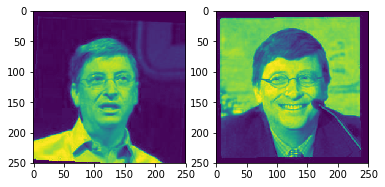

In [6]:
fig = plt.figure()
[ax1, ax2] = [fig.add_subplot(1,2,i+1) for i in range(2)]
ax1.imshow(im[0,:,:])
ax2.imshow(im[3,:,:])
plt.show()

Note how one entry from the training data (`X_train_original[51,:,:,:]`) contains two images. This is because one entry has shape `[6,250,250]` - it is storing 6 channels for a 250 x 250 image. The first 3 channels are for the face image on the left (above), and the second three channels are for the face image on the right (above). We can also check whether these are images are both of Willy Gates:

In [7]:
print(y_train_original[51])

[1]


In [8]:
# Original images are 250 x 250
print(im.shape)

(6, 250, 250)


<a name="xform"></a>
## Transforming the Image Data

In this section we'll go through a few transforms that will make the image data easier for the convolutional neural network to deal with, and make training go faster. We'll crop the images around the face to make them smaller, then downsmaple (pixellate) them to make them even smaller.

In [9]:
# Crop the image to 128 x 128

# Do a little margin math
current_dim = 250
target_dim = 128
margin = int((current_dim - target_dim)/2)
left_margin = margin
right_margin = current_dim - margin

newim = im[:, left_margin:right_margin, left_margin:right_margin]
print(newim.shape)

(6, 128, 128)


In [10]:
# This transpose is mainly useful for plotting with color:
# Put the images in standard dimension order
# (width, height, channels)
sized1 = newim[0:3,:,:]
sized1 = np.transpose(sized1,(1,2,0))

sized2 = newim[3:6,:,:]
sized2 = np.transpose(sized2,(1,2,0))

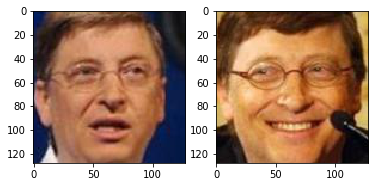

In [11]:
fig = plt.figure()
[ax1, ax2] = [fig.add_subplot(1,2,i+1) for i in range(2)]

ax1.imshow(sized1)
ax2.imshow(sized2)
plt.show()

These cropped faces are better for training the neural network (eliminate extraneous information/detail), but 128 x 128 is a rather large image, and training will go slowly. We can speed up training by downsampling the images using Numpy's `imresize()` function.

Start with 32 x 32:

In [12]:
feature_width = feature_height = 32

resized1_32 = imresize(newim[0:3,:,:], (feature_width, feature_height), interp="bicubic", mode="RGB")
resized2_32 = imresize(newim[3:6,:,:], (feature_width, feature_height), interp="bicubic", mode="RGB")
print(resized1_32.shape)
print(resized2_32.shape)

(32, 32, 3)
(32, 32, 3)


In [13]:
feature_width = feature_height = 64

resized1_64 = imresize(newim[0:3,:,:], (feature_width, feature_height), interp="bicubic", mode="RGB")
resized2_64 = imresize(newim[3:6,:,:], (feature_width, feature_height), interp="bicubic", mode="RGB")
print(resized1_64.shape)
print(resized2_64.shape)

(64, 64, 3)
(64, 64, 3)


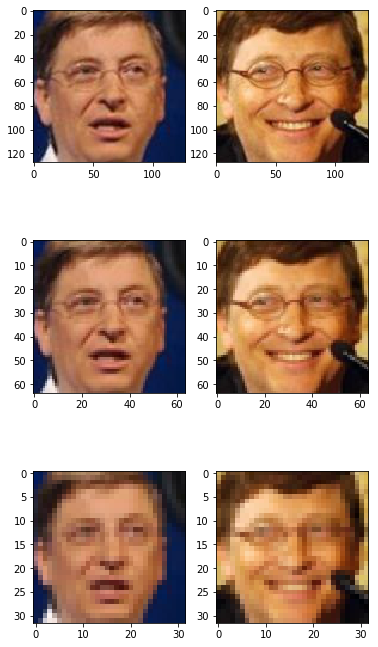

In [14]:
fig = plt.figure(figsize=(6,12))
[ax1, ax2, ax3, ax4, ax5, ax6] = [fig.add_subplot(3,2,i+1) for i in range(6)]

ax1.imshow(sized1)
ax2.imshow(sized2)
ax3.imshow(resized1_64)
ax4.imshow(resized2_64)
ax5.imshow(resized1_32)
ax6.imshow(resized2_32)
plt.show()

<a name="loadxform"></a>
## Building Load-Transform Functions

Now that we've explored the format of the images immediately after loading and worked out some basic transformations to make the data easier for training the model, we should bundle these into one or two function calls that we can then apply to the entire data set immediately after loading. Then we can have one function call to load the data from fuel, and another function call to transform the data and get it ready for training.

Once that's finished, we'll be ready to build and train the convolutional neural network!

Let's revisit the original data:

In [15]:
print(X_train_original[0,:,:,:].shape)

(6, 250, 250)


In [16]:
current_dim = 250
target_dim = 128
margin = int((current_dim - target_dim)/2)
left_margin = margin
right_margin = current_dim - margin

# newim is shape (6, 128, 128)
newim = im[:, left_margin:right_margin, left_margin:right_margin]

# resized are shape (feature_width, feature_height, 3)
feature_width = feature_height = 32
resized1 = imresize(newim[0:3,:,:], (feature_width, feature_height), interp="bicubic", mode="RGB")
resized2 = imresize(newim[3:6,:,:], (feature_width, feature_height), interp="bicubic", mode="RGB")

# re-packge into a new X entry
newX = np.concatenate([resized1,resized2], axis=2)

Now let's make sure this outputs sensible images, and then bundle it up into a function:

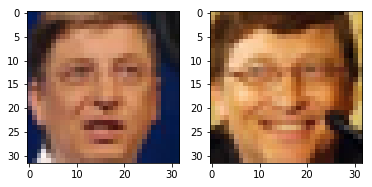

In [17]:
fig = plt.figure()
ax1, ax2 = [fig.add_subplot(1,2,i+1) for i in range(2)]
ax1.imshow(newX[:,:,0:3])
ax2.imshow(newX[:,:,3:6])

In [18]:
def crop_and_downsample(originalX, downsample_size=32):
    """
    Starts with a 250 x 250 image.
    Crops to 128 x 128 around the center.
    Downsamples the image to (downsample_size) x (downsample_size).
    Returns an image with dimensions (channel, width, height).
    """
    current_dim = 250
    target_dim = 128
    margin = int((current_dim - target_dim)/2)
    left_margin = margin
    right_margin = current_dim - margin

    # newim is shape (6, 128, 128)
    newim = im[:, left_margin:right_margin, left_margin:right_margin]

    # resized are shape (feature_width, feature_height, 3)
    feature_width = feature_height = downsample_size
    resized1 = imresize(newim[0:3,:,:], (feature_width, feature_height), interp="bicubic", mode="RGB")
    resized2 = imresize(newim[3:6,:,:], (feature_width, feature_height), interp="bicubic", mode="RGB")

    # re-packge into a new X entry
    newX = np.concatenate([resized1,resized2], axis=2)
    return newX

Now iterate through the input data set, apply the function, and append the result to a list. Ultimately this will be turned into a map. If we wanted to be more efficient about this, we could create a second Fuel dataset using the transformed data, but doing it on the fly allows us to maintain flexibility around the transform step (and experiment with it).

In [19]:
X_subsample_original = X_train_original[50:60,:,:,:]
X_subsample_transformed = np.asarray([crop_and_downsample(x) for x in X_subsample_original])

print(X_subsample_original.shape)
print(X_subsample_transformed.shape)

(10, 6, 250, 250)
(10, 32, 32, 6)


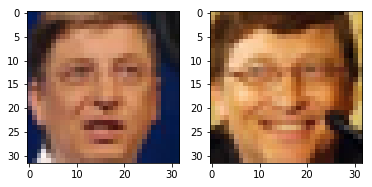

In [20]:
fig = plt.figure()
ax1, ax2 = [fig.add_subplot(1,2,i+1) for i in range(2)]

ax1.imshow(X_subsample_transformed[1,:,:,0:3])
ax2.imshow(X_subsample_transformed[1,:,:,3:6])

Now we have our finished product. We can load the LFW data set using:

```
(X_train_original, y_train_original), (X_test_original, y_test_original) = lfw.load_data("deepfunneled")
```

Then transform the data set via:

```
X_train = np.asarray([crop_and_downsample(x) for x in X_train_original])
X_test = np.asarray([crop_and_downsample(x) for x in X_test_original])
```